# More on views

In this notebook, we compare `DirectView` with `LoadBalancedView`

### Local setup

Some modules required for plotting and data organization. Since they won't be used by the parallel task, we only need to import locally.

In [1]:
import operator
import numpy as np
import pandas as pd

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
sns.set_context('talk')

### Parallel setup

In [2]:
from IPython.parallel import Client
rc = Client()
rc.ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

`Client.load_balanced_view()` return a new type of view that help balance the work load between engines.

In [3]:
dview = rc[:]
lbview = rc.load_balanced_view()

We here define a dummy task that sleeps for different amount of time. For this we need to import some built-in modules

In [4]:
%%px --local
from time import sleep
from datetime import datetime
import os
pid = os.getpid()  # every engines will be different

We use the engines' pid to track which task is executed by which process.

Note that if you are working with load-balanced view only, then using `asyncresult.metadata` will be sufficient.

In [5]:
engines_pid = dview.get('pid')
pid_id_map = {pid: id for pid, id in zip(engines_pid, rc.ids)}

## Task definition - target to troll directview.map

Here is a deliberately setup task, which determines each task's work load by argument `i`. Light load takes 200ms while havy one takes a second. However we only that the first bunch of `i`s to be heavy load.

In this case, when tasks are mapped acrossed engines, engine 0 will eat up all heavy tasks.

When each task finishes, the pid, start/end time are returned.

In [6]:
num_engines = len(rc.ids)
total_works = num_engines * 12 + 2

def high_variated_work(i):
    start_time = datetime.now()
    base_workload = 10
    if i  < (total_works // num_engines):
        base_workload *= 5
    # so short task: 200ms long task: 1s
    sleep(base_workload * 20 / 1000)
    end_time = datetime.now()
    return pid, start_time, end_time

First we test light/heavy task. The following line equals to `(end_t - start_t).total_seconds()`.

In [7]:
operator.sub(*high_variated_work(1)[:0:-1]).total_seconds()

1.006497

In [8]:
operator.sub(*high_variated_work(14)[:0:-1]).total_seconds()

0.203177

### Run and measure

Remember to spread all needed variable to remote engines.

In [9]:
dview['num_engines'] = num_engines
dview['total_works'] = total_works

In [10]:
# lb: load balance, ar: async result
lb_ar = lbview.map_async(high_variated_work, range(total_works))

In [11]:
lb_ar.wait_interactive()

 146/146 tasks finished after    3 s
done


In [12]:
# d: direct
d_ar = dview.map_async(high_variated_work, range(total_works))

In [13]:
d_ar.wait_interactive()

  12/12 tasks finished after   12 s
done


In [14]:
speedup = lambda ar: ar.serial_time / ar.wall_time
print(
    'Speedup for load-blanced and direct view (ideal: {:d}x): {:.2f} and {:.2f}'
    .format(num_engines, *map(speedup, [lb_ar, d_ar]))
)

Speedup for load-blanced and direct view (ideal: 12x): 11.23 and 3.23


### Collect and analyze meta

In [15]:
def parse_async_meta(async_result):
    """Parse async result as pandas.DataFrame"""
    meta_df = pd.DataFrame(async_result.get(), columns=['engine_pid', 'started', 'completed'])
    meta_df['engine_id'] = meta_df['engine_pid'].map(pid_id_map)
    return meta_df

In [16]:
def make_rel_time(meta_df):
    """Convert exact timestamp relative to start time and sort."""
    def compute_rel_time(col):
        """Relative time elapse compared with start time in seconds"""
        return [(val - start_time).total_seconds() for val in col]
    
    ## Make all time data relative to the start time in seconds
    # create empty dataframe
    df_rel_sec = meta_df[['engine_id']].copy()
    rel_columns = ['rel_started', 'rel_completed']
    for col in rel_columns:
        df_rel_sec[col] = np.empty(len(df_rel_sec), np.float)
        
    # get the earliest start time
    start_time = meta_df.started.min()
    abs_time_data = meta_df[['started', 'completed']]
    rel_time_data = abs_time_data.apply(compute_rel_time, axis=0).values
    df_rel_sec.loc[:, rel_columns] = rel_time_data
    
    # sort by relative start time and given order, 
    # grouped by different engines
    sorted_df = df_rel_sec.sort(['engine_id', 'rel_started', 'rel_completed'])
    sorted_df['order'] = np.empty(len(sorted_df), np.int)
    for grp_key, grp_df in sorted_df.groupby(['engine_id']):
        sorted_df.loc[grp_df.index, 'order'] = np.arange(len(grp_df))
    
    return sorted_df

In [17]:
# Functional style
lb_ar_df, d_ar_df = map(make_rel_time, map(parse_async_meta, [lb_ar, d_ar]))

### Visualization

In [18]:
def get_color_pal(max_jobs_per_engines):
    color_pal = sns.cubehelix_palette(
        n_colors=max_jobs_per_engines,
        start=2.3, rot=0.8, gamma=0.6, hue=0.8, 
        light=0.9, dark=0.3, 
        reverse=True
    )
    return color_pal


def plot_meta_df(meta_df, figsize=None):
    # some boundaries required for plotting
    max_jobs_per_engines = meta_df['order'].max() + 1
    num_engines = len(np.unique(meta_df['engine_id']))
    color_pal = get_color_pal(max_jobs_per_engines)
    
    if figsize is not None:
        fig = plt.figure(figsize=figsize)
    else:
        fig = plt.figure(figsize=(max_jobs_per_engines * 6 * 2 / 12, 6))
    ax = plt.axes()
    bar_height = 0.8
    for ix, row in meta_df.iterrows():
        plt.bar(
            bottom=int(row.engine_id) , left=row.rel_started, 
            width=row.rel_completed - row.rel_started, height=bar_height,
            color=color_pal[int(row['order'])], axes=ax
        )
    plt.xlabel('Time (second)')
    plt.ylabel('Engine')
    plt.yticks(
        np.arange(num_engines) + bar_height / 2, 
        ['%2d' % ix for ix in np.arange(num_engines)]
    )
    return fig

`get_color_pal(num_palettes)` is a function to produce a series of color specs which can be used to tell how many task each engine consumes.

At any time point, if engines' tasks has different color imply they are of different order.

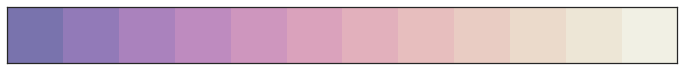

In [19]:
sns.palplot(get_color_pal(12))

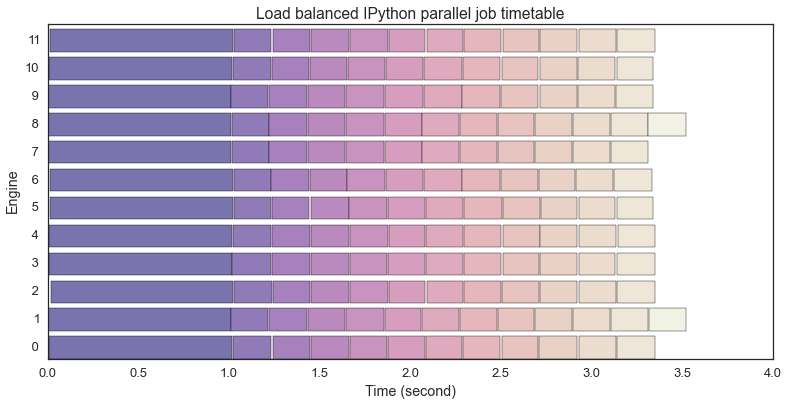

In [20]:
fig = plot_meta_df(lb_ar_df)
plt.title('Load balanced IPython parallel job timetable')
plt.show()

In [21]:
# fig.savefig("../../slides/pics/task_exe_history_load_balanced.svg", dpi="150", frameon=False, bbox_inches='tight')

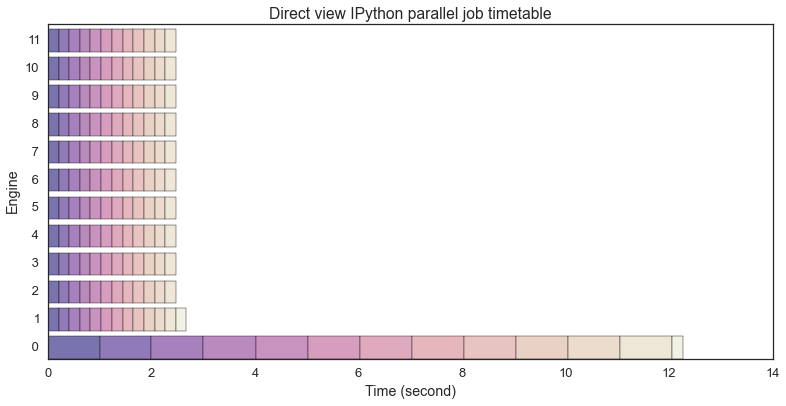

In [22]:
fig = plot_meta_df(d_ar_df)
plt.title('Direct view IPython parallel job timetable')
plt.show()

In [23]:
# fig.savefig("../../slides/pics/task_exe_history_direct.svg", dpi="150", frameon=False, bbox_inches='tight')

So it is apparent that we successfully *trolled* the direct view mapping mechanism. In real world this scenario is rare actually.

## Task definition - random work load

Here we use decorator to specify function to be parallelized.

In [24]:
@lbview.parallel(block=False)
def lb_randomized_work(work_load):
    start_time = datetime.now()
    sleep(work_load * 100 / 1000)
    end_time = datetime.now()
    return pid, start_time, end_time

@dview.parallel(block=False)
def d_randomized_work(work_load):
    start_time = datetime.now()
    sleep(work_load * 100 / 1000)
    end_time = datetime.now()
    return pid, start_time, end_time

Techinal detail here, we simulate the work load using [Gamma distribution](http://en.wikipedia.org/wiki/Gamma_distribution). Its probability distribution spans only on positive numbers and has long tail on larger number. This means this task tend to have some long running tasks.

We use `RandomState` to make sure every time we execute the random tasks are the same.

In [25]:
rs = np.random.RandomState(seed=9527)
rand_work_load = rs.gamma(shape=7.5, scale=0.5, size=num_engines * 15)

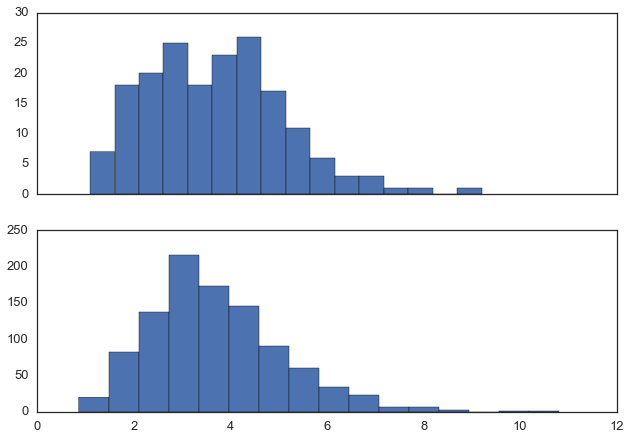

In [26]:
f, axarr = plt.subplots(2, sharex=True)
axarr[0].hist(rand_work_load, bins=16)
axarr[1].hist(rs.gamma(shape=7.5, scale=0.5, size=1000), bins=16)
plt.show()

In [27]:
lb_ar = lb_randomized_work.map(rand_work_load)
lb_ar.wait_interactive()

 180/180 tasks finished after    5 s
done


In [28]:
d_ar = d_randomized_work.map(rand_work_load)
d_ar.wait_interactive()

  12/12 tasks finished after    6 s
done


In [29]:
lb_ar_df, d_ar_df = map(make_rel_time, map(parse_async_meta, [lb_ar, d_ar]))

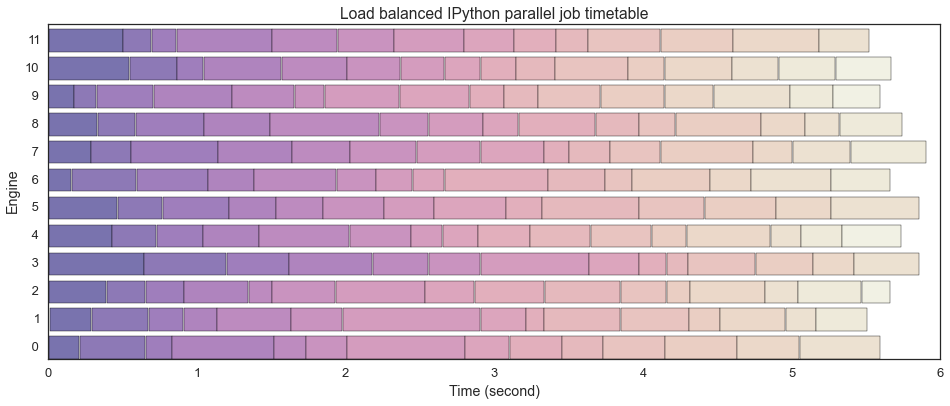

In [30]:
fig = plot_meta_df(lb_ar_df)
plt.title('Load balanced IPython parallel job timetable')
plt.show()

In [31]:
# fig.savefig("../../slides/pics/task_random_load_balanced.svg", dpi="150", frameon=False, bbox_inches='tight')

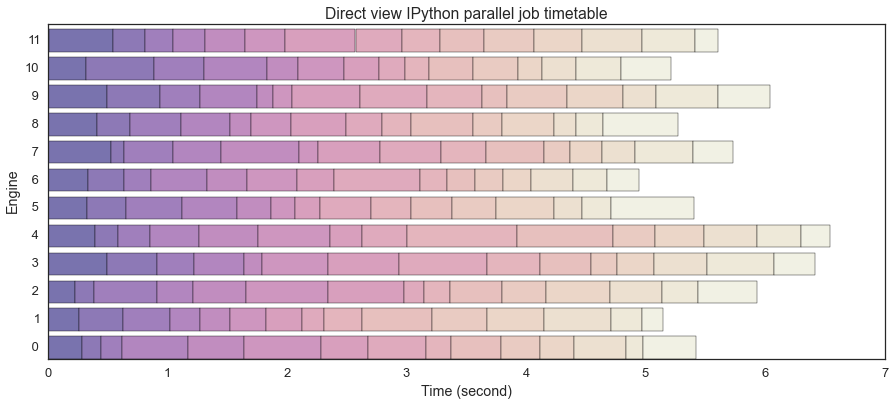

In [32]:
fig = plot_meta_df(d_ar_df)
plt.title('Direct view IPython parallel job timetable')
plt.show()

In [33]:
# fig.savefig("../../slides/pics/task_random_direct.svg", dpi="150", frameon=False, bbox_inches='tight')

In random tasks, their difference gets smaller. Though in this case the load-balanced case works more efficiently.